# 使用U-Net進行語意分割

# 程式參考來源：
https://keras.io/examples/vision/oxford_pets_image_segmentation/

## 下載資料
- 原圖：http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
- 註解：http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

## 載入相關套件

In [1]:
# 載入相關套件
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import PIL
from PIL import ImageOps
import numpy as np
import os
from IPython.display import Image, display

C:\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## 取得原圖及目標圖遮罩(Mask)的檔案路徑

In [2]:
# 訓練資料集路徑
root_path = "F:/0_DataMining/0_MY/Keras/ImageSegmentData/"
input_dir = root_path + "images/"               # 原圖目錄位置
target_dir = root_path + "annotations/trimaps/" # 遮罩圖(Mask)目錄位置

# 超參數設定
img_size = (160, 160) # 圖像寬高
num_classes = 4       # 類別個數
batch_size = 32       # 訓練批量

# 取得所有圖檔案路徑
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

# 取得所有遮罩圖檔案路徑
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("樣本數:", len(input_img_paths))

樣本數: 7390


In [3]:
# 顯示前10筆資料
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

F:/0_DataMining/0_MY/Keras/ImageSegmentData/images/Abyssinian_1.jpg | F:/0_DataMining/0_MY/Keras/ImageSegmentData/annotations/trimaps/Abyssinian_1.png
F:/0_DataMining/0_MY/Keras/ImageSegmentData/images/Abyssinian_10.jpg | F:/0_DataMining/0_MY/Keras/ImageSegmentData/annotations/trimaps/Abyssinian_10.png
F:/0_DataMining/0_MY/Keras/ImageSegmentData/images/Abyssinian_100.jpg | F:/0_DataMining/0_MY/Keras/ImageSegmentData/annotations/trimaps/Abyssinian_100.png
F:/0_DataMining/0_MY/Keras/ImageSegmentData/images/Abyssinian_101.jpg | F:/0_DataMining/0_MY/Keras/ImageSegmentData/annotations/trimaps/Abyssinian_101.png
F:/0_DataMining/0_MY/Keras/ImageSegmentData/images/Abyssinian_102.jpg | F:/0_DataMining/0_MY/Keras/ImageSegmentData/annotations/trimaps/Abyssinian_102.png
F:/0_DataMining/0_MY/Keras/ImageSegmentData/images/Abyssinian_103.jpg | F:/0_DataMining/0_MY/Keras/ImageSegmentData/annotations/trimaps/Abyssinian_103.png
F:/0_DataMining/0_MY/Keras/ImageSegmentData/images/Abyssinian_104.jpg | F:/0

## 顯示其中一張圖

F:/0_DataMining/0_MY/Keras/ImageSegmentData/images/Abyssinian_107.jpg


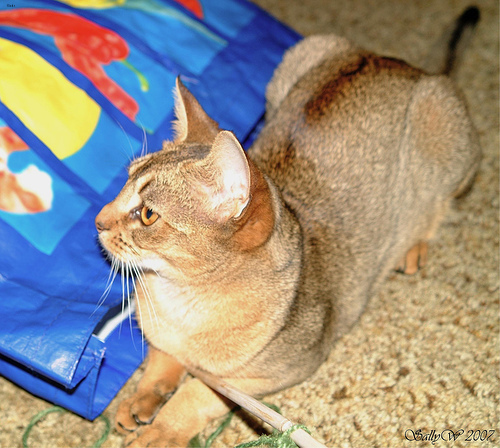

F:/0_DataMining/0_MY/Keras/ImageSegmentData/annotations/trimaps/Abyssinian_107.png


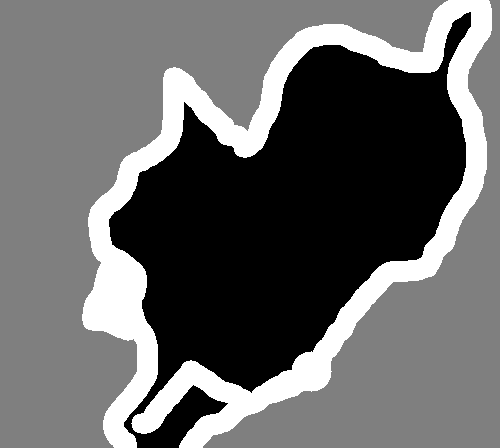

In [4]:
# 顯示第10張圖
print(input_img_paths[9])
display(Image(filename=input_img_paths[9]))

# 調整對比，將最深的顏色當作黑色(0)，最淺的顏色當作白色(255)
print(target_img_paths[9])
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## 建立圖像的 Iterator，一次傳回一批影像

In [5]:
# 建立圖像的 Iterator
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

## 建立 U-Net 模型

In [6]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    # 編碼器
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual

    # 除了特徵圖大小，三個區塊均相同
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # 殘差層(residual)
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # 解碼器
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # 殘差層(residual)
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # per-pixel 卷積
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", 
                            padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

In [7]:
# 釋放記憶體，以防執行多次造成記憶體的佔用
keras.backend.clear_session()

# 建立模型
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# 繪製模型結構

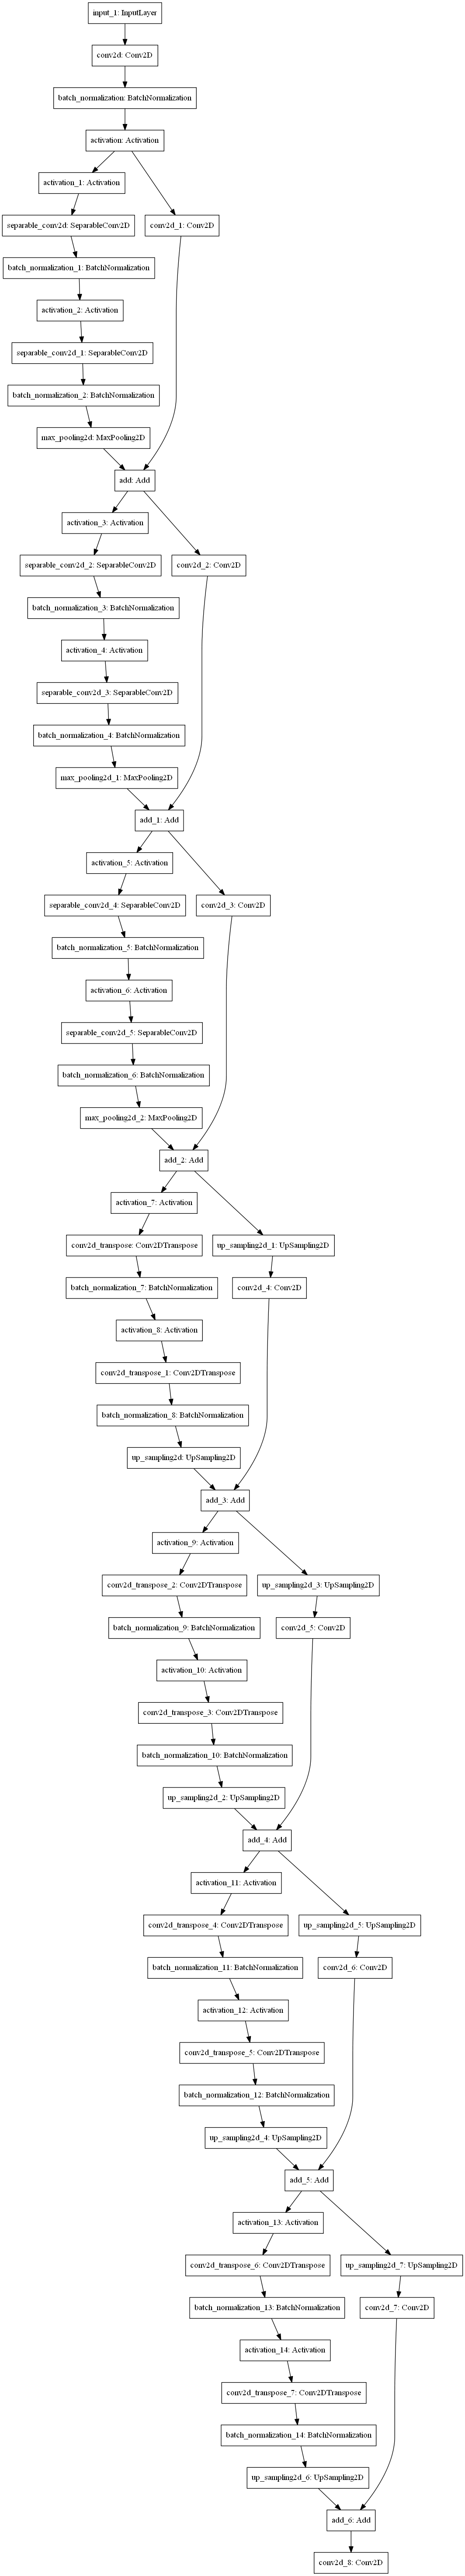

In [8]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='Unet_model.png')

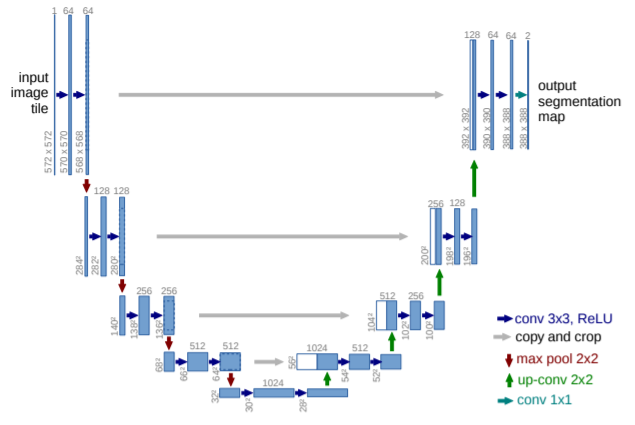

In [9]:
# 圖片來源：https://arxiv.org/pdf/1505.04597.pdf
from IPython.display import Image
Image('./images/U-Net.png', width=500)

## 將資料切割為訓練及驗證資料

In [10]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, 
                     val_target_img_paths)

## 訓練模型

In [11]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# 設定檢查點 callbacks，模型存檔
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# 訓練 15 週期(epoch)
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 100s 468ms/step - loss: 1.8252 - val_loss: 2.1718
Epoch 2/15
199/199 [==============================] - 92s 464ms/step - loss: 0.5354 - val_loss: 1.7744
Epoch 3/15
199/199 [==============================] - 92s 464ms/step - loss: 0.4431 - val_loss: 0.4589
Epoch 4/15
199/199 [==============================] - 92s 463ms/step - loss: 0.3979 - val_loss: 0.4685
Epoch 5/15
199/199 [==============================] - 93s 466ms/step - loss: 0.3576 - val_loss: 0.5853
Epoch 6/15
199/199 [==============================] - 93s 469ms/step - loss: 0.3238 - val_loss: 0.3721
Epoch 7/15
199/199 [==============================] - 93s 466ms/step - loss: 0.2966 - val_loss: 0.3841
Epoch 8/15
199/199 [==============================] - 94s 470ms/step - loss: 0.2766 - val_loss: 0.4457
Epoch 9/15
199/199 [==============================] - 95s 477ms/step - loss: 0.2595 - val_loss: 0.4165
Epoch 10/15
199/199 [==============================] - 94s 474ms/step - 

## 預測

原圖：


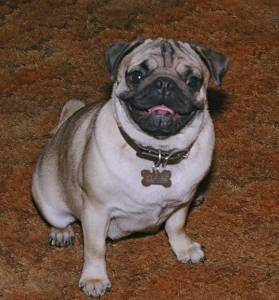

原遮罩圖：


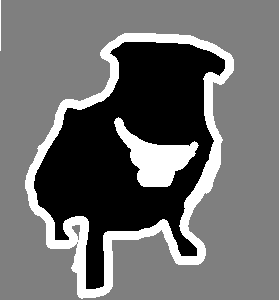

預測結果：


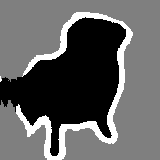

In [12]:
# 預測所有驗證資料
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, 
                     val_target_img_paths)
val_preds = model.predict(val_gen)

# 顯示遮罩(mask)
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

# 顯示驗證資料第11個圖檔
i = 10
# 顯示原圖
print('原圖：')
display(Image(filename=val_input_img_paths[i]))

# 顯示原圖遮罩(mask)
print('原遮罩圖：')
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# 顯示預測結果
print('預測結果：')
display_mask(i)  # Note that the model only sees inputs at 150x150.